In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [2]:
data = fetch_openml('Kuzushiji-MNIST')

In [3]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

(-0.5, 27.5, 27.5, -0.5)

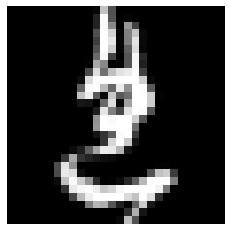

In [4]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')

In [5]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train,
                                                  random_state = 0)

In [6]:
# Hyperparameters to tune: learning rate, beta values, bottleneck size, 
lr = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1]
B1 = 0.9
B2 = 0.999
bottleneck = [10, 20, 50, 75, 100, 150]

scores = np.zeros((len(lr), len(bottleneck)))


In [13]:
for ii in range(len(bottleneck)):
    for jj in range(len(lr)):
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck[ii],  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr[jj],
                            beta_1=B1,
                            beta_2=B2))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=50, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
        
        scores[jj, ii] = min(history.history['val_loss'])

[[0.0432524  0.03659417 0.02626092 0.01831602 0.0156834  0.01228416]
 [0.04496935 0.04221988 0.02656882 0.02103805 0.01705976 0.01455829]
 [0.05571628 0.04508123 0.03096399 0.03131596 0.0234615  0.02072244]
 [0.06300911 0.06141164 0.05237832 0.05030794 0.04353024 0.04842895]
 [0.10334791 0.15768802 0.1034373  0.06292148 0.06606883 0.06259905]
 [0.15768802 0.15768802 0.08930925 0.0766583  0.07548341 0.08798049]
 [0.15768802 0.15768802 0.15768802 0.15768802 0.1059144  0.15768802]]


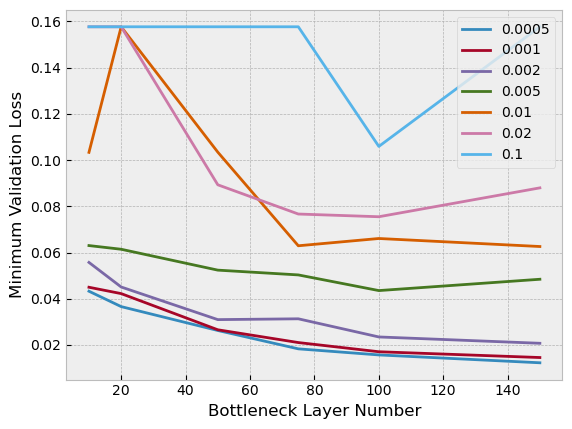

In [18]:
print(scores)
plt.figure()
plt.plot(bottleneck, scores[0,:])
plt.plot(bottleneck, scores[1,:])
plt.plot(bottleneck, scores[2,:])
plt.plot(bottleneck, scores[3,:])
plt.plot(bottleneck, scores[4,:])
plt.plot(bottleneck, scores[5,:])
plt.plot(bottleneck, scores[6,:])
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')
plt.legend(lr)

# Tuning loss rate and bottleneck layers
As expected, since ADAM helps learning overcome small local minimas, the validation loss in image reconstruction decreases with decreasing learning rate, as long as enough training time is given. Somewhat unexpected is how much increasing the number of nodes in the bottleneck layer increases performance. In PCA, to keep 99.9% of the explained variance of each image, only 16 dimensions are needed on average. But we continue to see much better berformance as we increase bottleneck layer nodes up to 150. The lowest value is in the corner of our grid, but for training time purposes, we will keep the learning rate at 0.0005 as lower learning rates may need many more iterations to properly train. We will now check more units in the bottleneck layer to see where we no longer gain extra performance

In [20]:
bottleneckNum  = [125, 150, 200, 250, 300, 350, 400]
scores2 = np.zeros(len(bottleneckNum))
lr = 0.0005

for ii in range(len(bottleneck)):
    
    encoder = models.Sequential([
        layers.Flatten(input_shape=[28,28]),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(bottleneckNum[ii],  activation='relu', use_bias=False)
    ])

    decoder = models.Sequential([
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(28*28, use_bias=False),
        layers.Reshape([28, 28])
    ])

    autoencoder = models.Sequential([encoder, decoder])

    autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                        optimizer=optimizers.Adam(learning_rate=lr,
                        beta_1=B1,
                        beta_2=B2))
    
    callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(X_train, X_train, epochs=100, 
                validation_data=(X_val, X_val),
                callbacks=callback1,
                verbose=0)
        
    scores2[ii] = min(history.history['val_loss'])

[0.01213735 0.01158006 0.00972538 0.0102109  0.00936456 0.00923875
 0.00920107]


Text(0, 0.5, 'Minimum Validation Loss')

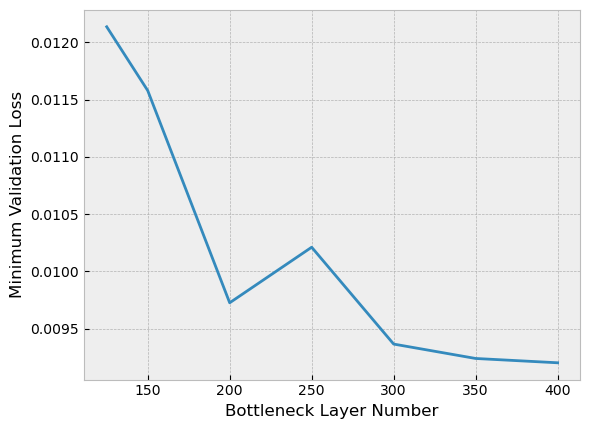

In [21]:
print(scores2)
plt.figure()
plt.plot(bottleneckNum, scores2)
plt.xlabel('Bottleneck Layer Number')
plt.ylabel('Minimum Validation Loss')

In [22]:
# Tune the beta hyperparameters for adam to possibly increase convergence rate. Beta values need to be less than 1
bottleneckNum  = 200

lr = 0.0005
B1 = [0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975]
B2 = [0.995, 0.996, 0.997, 0.998, 0.999]
scores2 = np.zeros((len(B1),len(B2)))
numIter = np.zeros((len(B1),len(B2)))

for ii in range(len(B1)):
    
    for jj in range(len(B2)):
    
        encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

        decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

        autoencoder = models.Sequential([encoder, decoder])

        autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                            optimizer=optimizers.Adam(learning_rate=lr,
                            beta_1=B1[ii],
                            beta_2=B2[jj]))
        
        callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = autoencoder.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1,
                    verbose=0)
             
        scores2[ii, jj] = min(history.history['val_loss'])
        numIter[ii, jj] = len(history.history['val_loss'])

In [26]:
# print(scores2)
# print(numIter)
print(scores2.shape)
print(np.argmin(scores2))

print('Lowest Val loss was with beta 1 = ', B1[2], ' and beta 2 = ', B2[2])

(7, 5)
12
Lowest Val loss was with beta 1 =  0.875  and beta 2 =  0.997


In [27]:
# Train Final Base SAE
bottleneckNum  = 200
lr = 0.0005
B1 = 0.875
B2 = 0.997

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

historySAE = autoencoder.fit(X_train, X_train, epochs=100, 
            validation_data=(X_val, X_val),
            callbacks=callback1,
            verbose=1)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0370 - val_loss: 0.0249
Epoch 2/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0187 - val_loss: 0.0179
Epoch 5/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0170 - val_loss: 0.0168
Epoch 7/100
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

In [29]:
encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(encoder.layers)-1].output)

# Define the decoder model
latent_input = layers.Input(shape=(bottleneckNum,))  # Latent space shape (bottleneckNum, )
decoder_output = autoencoder.layers[len(encoder.layers):](latent_input)
decoder_model = models.Model(latent_input, decoder_output)

IndexError: list index out of range

In [31]:
print(len(encoder.layers))
print(len(autoencoder.layers))

4
2


In [32]:
# Save the model weights
autoencoder.save_weights('SAE_weights.h5')
encoder.save_weights('SAE_encoder_weights.h5')
decoder.save_weights('SAE_decoder_weights.h5')

In [ ]:
# callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = autoencoder.fit(X_train, X_train, epochs=50, 
#                     validation_data=(X_val, X_val),
#                     callbacks=callback1)

Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0663 - val_loss: 0.0596
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0571 - val_loss: 0.0566
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0555 - val_loss: 0.0557
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0547 - val_loss: 0.0545
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0542 - val_loss: 0.0541
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0540 - val_loss: 0.0546
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0536 - val_loss: 0.0545
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0535 - val_loss: 0.0532
Epoch 9/50
1500/1500 [==============================] - 2s 2ms/step - loss: 0.0534 - val_loss: 0.0540
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/step - loss: 0.053

In [ ]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Loading Trained Model

In [7]:
bottleneckNum = 200

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

In [8]:
autoencoder.load_weights('SAE_weights.h5')
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

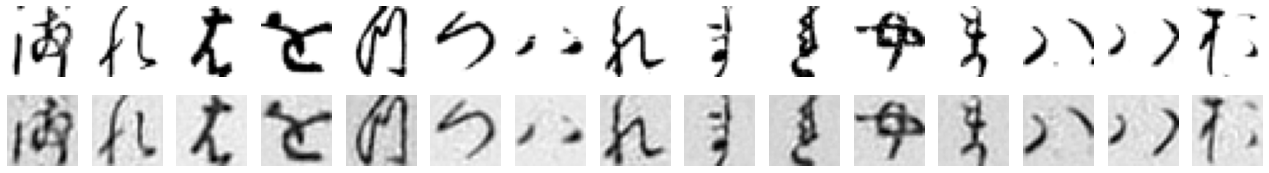

In [9]:
# visualize images reconstructed from encodings
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, n_images=15):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(autoencoder)

The reconstructions look really good!!

# Using Encoder to Train a Classifier

### Encoding Data

In [10]:
codings_train = encoder.predict(X_train)
codings_val = encoder.predict(X_val)
codings_test = encoder.predict(X_test)

### Single-Layer MLP

In [12]:
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
patience = 10
epochs = 500

optimizer = optimizers.Nadam(learning_rate = learning_rate, 
                                   beta_1 = beta_1, beta_2 = beta_2)

callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = patience,
                                         restore_best_weights = True)

In [ ]:
N1_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N1_vals), 2))

In [122]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    print('Training NN of size:', N1)

    classifier = models.Sequential([
        layers.Input(shape=(bottleneckNum,)),
        layers.Dense(N1, activation = 'sigmoid'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback])
    
    test_performance[N1_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [123]:
print(test_performance)

[[0.48953027 0.85820001]
 [0.40911284 0.88550001]
 [0.37980753 0.89039999]
 [0.36242145 0.89740002]
 [0.34266391 0.90570003]]


The larger the layer the size, the greater the performance.

### Double-Layer MLP

In [124]:
epochs = 200
N1 = 1024
N2_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N2_vals), 2))

In [125]:
for N2_idx, N2 in np.ndenumerate(N2_vals):
    print('Training NN of size:', (N1, N2))

    classifier = models.Sequential([
        layers.Input(shape=(bottleneckNum,)),
        layers.Dense(N1, activation = 'sigmoid'),
        layers.Dense(N2, activation = 'sigmoid'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback])
    
    test_performance[N2_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [126]:
print(test_performance)

[[0.37794372 0.90350002]
 [0.36388978 0.9023    ]
 [0.36495817 0.9023    ]
 [0.36449355 0.90259999]
 [0.37545308 0.89789999]]


Adding a second layer improved performance overall. However, increasing the size of the second layer did not guarantee better performance, as was seen with the first layer.

In [127]:
N1_vals = [64, 128, 256, 512, 1024]
N2_vals = [64, 128, 256, 512, 1024]

test_performance = np.zeros((len(N1_vals), len(N2_vals), 2))

In [128]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    for N2_idx, N2 in np.ndenumerate(N2_vals):
        print('Training NN of size:', (N1, N2))

        classifier = models.Sequential([
            layers.Input(shape=(bottleneckNum,)),
            layers.Dense(N1, activation = 'sigmoid'),
            layers.Dense(N2, activation = 'sigmoid'),
            layers.Dense(10, activation = 'softmax')
        ])

        classifier.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                 metrics = ['accuracy'])

        history = classifier.fit(codings_train, t_train, epochs = epochs,
                            batch_size = 2048,
                            validation_data = (codings_val, t_val),
                            callbacks = [callback])

        test_performance[N1_idx, N2_idx, :] = classifier.evaluate(codings_test, t_test)

        clear_output()

In [129]:
print(test_performance)

[[[0.51237512 0.85140002]
  [0.52210546 0.84630001]
  [0.53897923 0.83810002]
  [0.53826159 0.84609997]
  [0.5302223  0.85140002]]

 [[0.46265453 0.86360002]
  [0.45020542 0.87159997]
  [0.44902217 0.87059999]
  [0.47295269 0.86769998]
  [0.45795894 0.86830002]]

 [[0.42745942 0.87220001]
  [0.41553915 0.88029999]
  [0.41856143 0.87919998]
  [0.44075537 0.8818    ]
  [0.47822973 0.86669999]]

 [[0.40099734 0.88569999]
  [0.39726269 0.88489997]
  [0.38657168 0.89170003]
  [0.39354718 0.89090002]
  [0.47756079 0.86299998]]

 [[0.37993911 0.88990003]
  [0.38767695 0.88489997]
  [0.36823192 0.8937    ]
  [0.38343483 0.88789999]
  [0.40710509 0.88690001]]]


The classifier performed best with layers of size 1024-256.

### Triple-Layer MLP

In [11]:
epochs = 500
N1 = 1024
N2 = 256
N3_vals = [16, 32, 64, 128]

test_performance = np.zeros((len(N3_vals), 2))

In [12]:
for N3_idx, N3 in np.ndenumerate(N3_vals):
    print('Training NN of size:', (N1, N2, N3))

    classifier = models.Sequential([
        layers.Input(shape=(bottleneckNum,)),
        layers.Dense(N1, activation = 'sigmoid'),
        layers.Dense(N2, activation = 'sigmoid'),
        layers.Dense(N3, activation = 'sigmoid'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback])
    
    test_performance[N3_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [132]:
print(test_performance)

[[0.42603672 0.88800001]
 [0.38342118 0.89929998]
 [0.40483472 0.89270002]
 [0.42078292 0.89090002]]


The classifier performed best with size 1024-256-32. 

Multiple layers were experimented with, but the best performing model was still the single layer MLP with 1024 nodes.

### Trying a Single Layer Again

In [ ]:
N1_vals = [1024, 2048, 4096]

test_performance = np.zeros((len(N1_vals), 2))

In [14]:
for N1_idx, N1 in np.ndenumerate(N1_vals):
    print('Training NN of size:', N1)

    classifier = models.Sequential([
        layers.Input(shape=(bottleneckNum,)),
        layers.Dense(N1, activation = 'sigmoid'),
        layers.Dense(10, activation = 'softmax')
    ])
    
    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])
    
    history = classifier.fit(codings_train, t_train, epochs = epochs,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback])
    
    test_performance[N1_idx, :] = classifier.evaluate(codings_test, t_test)
    
    clear_output()

In [15]:
print(test_performance)

[[0.34380713 0.9041    ]
 [0.34926897 0.90240002]
 [0.34695509 0.90369999]]


To me, it seems that a single layer gets the job done and performs comparably, if not better, to the deeper MLPs. This last run also seems to suggest that, beyond a certain number, increasing the size of that layer doesn't make meaningful improvements to performance. 

Our MLP from Project 1 was getting a training accuracy of 89.52%. Encoding the training data hasn't seem to have had a significant effect on model performance. I suppose this is good, as training times are lower than before.

## Training and Evaluating Final Codings Classifier

In [13]:
classifier = models.Sequential([
    layers.Input(shape=(bottleneckNum,)),
    layers.Dense(1024, activation = 'sigmoid'),
    layers.Dense(10, activation = 'softmax')
])

classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = classifier.fit(codings_train, t_train, epochs = epochs,
                    batch_size = 1024,
                    validation_data = (codings_val, t_val),
                    callbacks = [callback])

Epoch 1/500
47/47 [==============================] - 1s 8ms/step - loss: 2.0509 - accuracy: 0.3716 - val_loss: 1.7510 - val_accuracy: 0.5642
Epoch 2/500
47/47 [==============================] - 0s 6ms/step - loss: 1.5165 - accuracy: 0.6476 - val_loss: 1.3207 - val_accuracy: 0.6785
Epoch 3/500
47/47 [==============================] - 0s 6ms/step - loss: 1.1906 - accuracy: 0.6973 - val_loss: 1.0791 - val_accuracy: 0.7210
Epoch 4/500
47/47 [==============================] - 0s 6ms/step - loss: 1.0049 - accuracy: 0.7295 - val_loss: 0.9551 - val_accuracy: 0.7287
Epoch 5/500
47/47 [==============================] - 0s 6ms/step - loss: 0.8954 - accuracy: 0.7500 - val_loss: 0.8492 - val_accuracy: 0.7650
Epoch 6/500
47/47 [==============================] - 0s 6ms/step - loss: 0.8266 - accuracy: 0.7650 - val_loss: 0.8074 - val_accuracy: 0.7688
Epoch 7/500
47/47 [==============================] - 0s 6ms/step - loss: 0.7810 - accuracy: 0.7751 - val_loss: 0.7519 - val_accuracy: 0.7815
Epoch 8/500
4

In [14]:
y_proba_train = classifier.predict(codings_train)
y_proba_test = classifier.predict(codings_test)
y_train = np.argmax(y_proba_train, axis=1)
y_test = np.argmax(y_proba_test, axis=1)

Performance in training:
1500/1500 [==============================] - 1s 832us/step - loss: 0.0396 - accuracy: 0.9927


[0.03956827148795128, 0.9927083253860474]

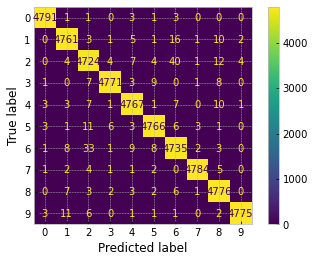

In [15]:
print('Performance in training:')
conf_mx = confusion_matrix(t_train, y_train)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier.evaluate(codings_train, t_train)

Performance in test:
313/313 [==============================] - 0s 637us/step - loss: 0.3442 - accuracy: 0.9045


[0.34420591592788696, 0.9045000076293945]

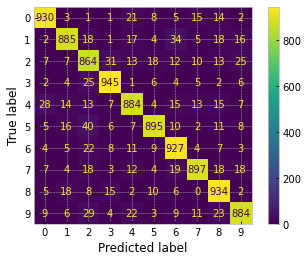

In [16]:
print('Performance in test:')
conf_mx = confusion_matrix(t_test, y_test)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
classifier.evaluate(codings_test, t_test)

# PCA as information for the bottleneck tuning
While SAE offers increased functionality to PCA by creating weights that can be used in other functions such as VAE generation, at its core the SAE training serves the same function as PCA: dimensionality reduction. To this end, to inform our bottleneck tuning we can use PCA on the data and figure out how many dimensions we can remove while keeping 95% of the variation

# Create a data generator
By using the trained SAE, we can generate new data with the addition of Gaussian noise in the latent vector space. 

In [16]:
import random

In [17]:
# Function to add noise to the input

def add_gaussian_noise(input_image, mean=0.0, stddev=0.1):
    # Add Gaussian noise with mean `mean` and standard deviation `stddev`
    noise = tf.random.normal(shape=tf.shape(input_image), mean=mean, stddev=stddev)
    noisy_image = input_image + noise
    return noisy_image

def generate_new_data(input_image, encoder_model, decoder_model, noise_mean=0.0, noise_stddev=0.1):
    # Encode the input image to get the latent space representation
    latent_rep = encoder_model(input_image)

    # Add Gaussian noise to the latent space
    noisy_latent_rep = latent_rep + tf.random.normal(shape=tf.shape(latent_rep), mean=noise_mean, stddev=noise_stddev)

    # Decode the noisy latent space back to the image
    new_image = decoder_model(noisy_latent_rep)

    return new_image

# encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[len(encoder.layers)-1].output)

# # Create the decoder model
# latent_input = layers.Input(shape=(bottleneckNum,))  # Latent space shape (bottleneckNum, )
# decoder_output = autoencoder.layers[len(encoder.layers):](latent_input)
# decoder_model = models.Model(latent_input, decoder_output)

In [138]:
# Load in the model
bottleneckNum  = 200
encoderLoad = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoderLoad = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
        ])

# Create dummy data to build the model
dummy_input1 = np.zeros((1, 28, 28))  # 1 sample, with shape matching the input of 28x28
dummy_input2 = np.zeros((200,200))

# Build the encoder and decoder by passing the dummy input
encoderLoad(dummy_input1)  # This forces the model to be built
decoderLoad(dummy_input2)  # This forces the model to be built

encoderLoad.load_weights('SAE_encoder_weights.h5')
decoderLoad.load_weights('SAE_decoder_weights.h5')

# Create a np array to store generated data
samps = 1000
newData = np.zeros((samps, 28, 28))

trainRange = X_train.shape[0]

for i in range(samps):
    rndPt = random.randint(0, trainRange-1)
    genIm = X_train[rndPt, :, :]
    genIm = np.expand_dims(genIm, axis=0)
    latentSpace = encoderLoad.predict(genIm)
    noisyLatent = add_gaussian_noise(latentSpace, mean=0.0, stddev=0.1)
    newIm = decoderLoad.predict(noisyLatent)
    newData[i,:,:] = newIm

(-0.5, 27.5, 27.5, -0.5)

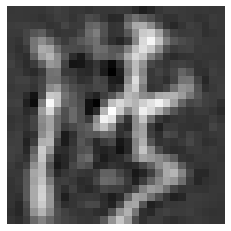

In [140]:
plt.figure()
plt.imshow(newData[241], cmap='gray')
plt.axis('off')

## Generating New Images by Adding Gaussian Noise to Codings

In [17]:
# sets apart a set of codings and labels with one from each class
other_condings, codings, other_labels, labels = train_test_split(codings_train, t_train, 
                                                  test_size = 10, # take ten samples
                                                  stratify = t_train, # t_train is evenly distributed in classes
                                                  random_state = 0)

In [18]:
def generate_images(codings, labels, stddev, decoder):
    '''give it a set of codings, one from each class, and it will make 1,000 new samples and their labels'''
    new_codings = codings
    new_labels = labels
    for i in np.arange(99): # this loop just copies the codings and labels enough to get 1000 samples
        new_codings = np.vstack((new_codings, codings))
        new_labels = np.hstack((new_labels, labels))
    noise = tf.random.normal(shape=tf.shape(new_codings), mean=0, stddev=stddev) # generate noise
    noisy_codings = new_codings + noise # add noise to codings
    new_images = decoder.predict(noisy_codings) # generate images from noisy codings
    return new_images, new_labels

In [19]:
new_images, new_labels = generate_images(codings, labels, 0.2, decoder)

Class: 6


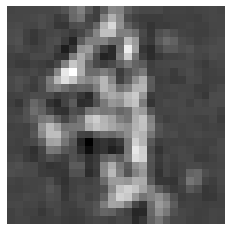

In [21]:
idx = 262
print('Class:', new_labels[idx])
plt.figure()
plt.imshow(new_images[idx], cmap='gray')
plt.axis('off');

## Project 1 Classifier Performance as a Function of Variance

In [44]:
callback = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 10,
                                         restore_best_weights = True)

optimizer = optimizers.Nadam(learning_rate = 0.001, 
                                   beta_1 = 0.9, beta_2 = 0.999)

Project1Classifier = models.Sequential([
    layers.Input(shape=(28,28)),
    layers.Flatten(),
    layers.Dense(256, activation = 'sigmoid'),
    layers.Dense(10, activation = 'sigmoid')
])

Project1Classifier.compile(loss = 'sparse_categorical_crossentropy',
         optimizer = optimizer,
         metrics = ['accuracy'])

history = Project1Classifier.fit(X_train, t_train, epochs = 500,
                    batch_size = 1024,
                    validation_data = (X_val, t_val),
                    callbacks = [callback])

Epoch 1/500
47/47 [==============================] - 1s 7ms/step - loss: 1.4421 - accuracy: 0.6268 - val_loss: 0.9365 - val_accuracy: 0.7557
Epoch 2/500
47/47 [==============================] - 0s 5ms/step - loss: 0.8052 - accuracy: 0.7842 - val_loss: 0.7131 - val_accuracy: 0.7989
Epoch 3/500
47/47 [==============================] - 0s 5ms/step - loss: 0.6654 - accuracy: 0.8122 - val_loss: 0.6288 - val_accuracy: 0.8174
Epoch 4/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5974 - accuracy: 0.8273 - val_loss: 0.5766 - val_accuracy: 0.8292
Epoch 5/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5492 - accuracy: 0.8406 - val_loss: 0.5361 - val_accuracy: 0.8402
Epoch 6/500
47/47 [==============================] - 0s 5ms/step - loss: 0.5086 - accuracy: 0.8510 - val_loss: 0.5006 - val_accuracy: 0.8530
Epoch 7/500
47/47 [==============================] - 0s 5ms/step - loss: 0.4732 - accuracy: 0.8613 - val_loss: 0.4678 - val_accuracy: 0.8619
Epoch 8/500
4

In [45]:
y_proba = Project1Classifier.predict(new_images)
y = np.argmax(y_proba, axis=1)

Performance of Project 1 classifier:
32/32 [==============================] - 0s 605us/step - loss: 0.4928 - accuracy: 0.8420


[0.4928086996078491, 0.8420000076293945]

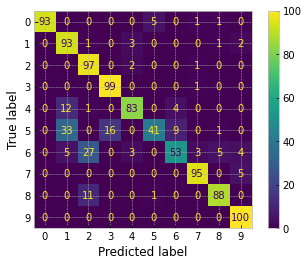

In [46]:
print('Performance of Project 1 classifier:')
conf_mx = confusion_matrix(new_labels, y)
disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
disp_cm.plot()
Project1Classifier.evaluate(new_images, new_labels)

Decent performance, but struggles with classes 5 and 6.

Class 5 and 6:


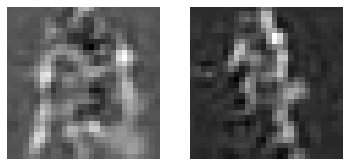

In [40]:
print('Class 5 and 6:' )
plt.figure()
plt.subplot(1,2,1)
plt.imshow(new_images[254], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(new_images[252], cmap='gray')
plt.axis('off');

In [63]:
stddev_vals = np.linspace(0, 1, 21)
accuracy = np.zeros((len(stddev_vals),2))

In [64]:
for idx, stddev in np.ndenumerate(stddev_vals):
    new_images, new_labels = generate_images(codings, labels, stddev, decoder)
    accuracy[idx,:] = Project1Classifier.evaluate(new_images, new_labels)

32/32 [==============================] - 0s 614us/step - loss: 4.7128 - accuracy: 0.1980


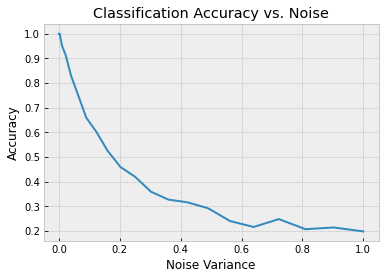

In [66]:
plt.figure()
plt.plot(stddev_vals**2, accuracy[:,1])
plt.xlabel('Noise Variance')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Noise');

# Bottleneck layer tuning
While increasing the number of bottleneck layer nodes continuously gives better performance, the point of the SAE is to create a latent space that is much smaller than the original dimensionality, so although 300, 350, and 400 nodes all have smaller loss than 200 nodes, the loss difference is relatively minimal, so we will use XXX of 200 in the bottleneck layer since it both decreases the dimensionality greatly, and much better reconstruction performance than having 150 or fewer nodes.

In [39]:
# Perform PCA to find out how much dimensionality reduction we can do
from sklearn.decomposition import PCA
expVar1 = 0.95
expVar2 = 0.99
expVar3 = 0.999


avg_dims1 = 0
avg_dims2 = 0
avg_dims3 = 0



for iii in range(X_train.shape[0]):
    
    my_pca1 = PCA(n_components = expVar1)
    my_pca2 = PCA(n_components = expVar2)
    my_pca3 = PCA(n_components = expVar3)

    my_pca1.fit(X_train[iii,:,:])
    my_pca2.fit(X_train[iii,:,:])
    my_pca3.fit(X_train[iii,:,:])
    
    avg_dims1 = avg_dims1 + len(my_pca1.explained_variance_ratio_)
    avg_dims2 = avg_dims2 + len(my_pca2.explained_variance_ratio_)
    avg_dims3 = avg_dims3 + len(my_pca3.explained_variance_ratio_)
    
avg_dims1 = avg_dims1 / X_train.shape[0]
avg_dims2 = avg_dims2 / X_train.shape[0]
avg_dims3 = avg_dims3 / X_train.shape[0]

In [40]:
print(avg_dims1)
print(avg_dims2)
print(avg_dims3)

7.1459375
11.061916666666667
15.506791666666667


In [48]:
# Train 3 autoencoders with these bottleneck layers and see the results
lr = 0.001
B1 = 0.9
B2 = 0.999
bottleneck1 = 8
bottleneck2 = 12
bottleneck3 = 16

encoder1 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck1,  activation='relu', use_bias=False)
])

encoder2 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck2,  activation='relu', use_bias=False)
])

encoder3 = models.Sequential([
    layers.Flatten(input_shape=[28,28]),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(bottleneck3,  activation='relu', use_bias=False)
])

decoder1 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder2 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

decoder3 = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder1 = models.Sequential([encoder1, decoder1])
autoencoder2 = models.Sequential([encoder2, decoder2])
autoencoder3 = models.Sequential([encoder3, decoder3])

autoencoder1.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder2.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

autoencoder3.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                    optimizer=optimizers.Adam(learning_rate=lr,
                    beta_1=B1,
                    beta_2=B2))

In [49]:
# training
callback1=callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history1 = autoencoder1.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history2 = autoencoder2.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

history3 = autoencoder3.fit(X_train, X_train, epochs=100, 
                    validation_data=(X_val, X_val),
                    callbacks=callback1)

Epoch 1/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0774 - val_loss: 0.0705
Epoch 2/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0670 - val_loss: 0.0649
Epoch 3/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0634 - val_loss: 0.0627
Epoch 4/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0614 - val_loss: 0.0614
Epoch 5/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0592 - val_loss: 0.0589
Epoch 6/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0573 - val_loss: 0.0574
Epoch 7/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0560 - val_loss: 0.0568
Epoch 8/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0551 - val_loss: 0.0560
Epoch 9/100
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0543 - val_loss: 0.0557
Epoch 10/100
1500/1500 [==============================] - 2s 1ms/step - l

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_51 (Sequential)   (None, 16)                790400    
_________________________________________________________________
sequential_54 (Sequential)   (None, 28, 28)            790400    
Total params: 1,580,800
Trainable params: 0
Non-trainable params: 1,580,800
_________________________________________________________________


In [51]:
# # Design an MLP classifier
# MLPClassifier = models.Sequential([
#     layers.Dense(400,  activation='relu', use_bias=False),
#     layers.Dense(600,  activation='relu', use_bias=False),
#     layers.Dense(800,  activation='relu', use_bias=False),
#     layers.Dense(10,  activation='softmax', use_bias=False)
# ])

# Keeping 99.9% of the variance with only 16 features in the bottleneck layer is a great tradeoff, and the loss was not bad in training

# Freeze the autoencoder3 for use in classification
for layer in autoencoder3.layers:
    layer.trainable = False
    
autoOut = autoencoder3.layers[-2].output

x = layers.Dense(450, activation='relu')(autoOut)  # MLP hidden layer
x = layers.Dense(128, activation='relu')(x)  # Another hidden layer
classifier_output = layers.Dense(10, activation='softmax')(x)

model_with_classifier = models.Model(inputs=autoencoder3.input, outputs=classifier_output)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='flatten_20_input'), name='flatten_20_input', description="created by layer 'flatten_20_input'") at layer "flatten_20". The following previous layers were accessed without issue: []

In [50]:
28**2

784

# Custom Loss Function
There are many possible loss functions for classification. However, for this project we have been given the template of using a distance formulation as such: $ R = 1/K\sum_{i=1}^{K} d_i $. We can make modifications to the lambda value that we multiply by R, the distance metric, the batch size K, and other implementation criteria. We will try euclidean distance (with latent space normalization), as well as a Manhattan block distance, and mahalanobis distances. Euclidian is a simple default and the normalization should ensure that distance is not dominated by whichever variable has the highest spread. Manhattan block distance [some reason]. Mahalanobis takes advantage of the variance to improve the distance metric.

In [ ]:
# custom SAE loss
from sklearn.preprocessing import StandardScaler

class customLoss(tf.keras.losses.Loss):
    def __init__(self, name="SAE_loss"):
        # You can initialize any additional parameters for your loss here
        super().__init__(name=name)

    def call(self, y_true, y_pred, lam):
        """
        This method defines the loss computation. The output of this function will
        be used to calculate the loss during training.

        Args:
            y_true: Tensor of true labels. Should be one-hot vector of size 10
            y_pred: Tensor of predicted values.
            lam: Scalar of regularization constant 

        Returns:
            A scalar Tensor representing the loss value.
        """
        # We want to scale the latent space for better distance calculation
        
        
        # Example of Mean Squared Error (MSE) loss
        loss_value = tf.reduce_mean(tf.square(y_true - y_pred))

        # Optionally, you can add more loss methods based on specific conditions
        # Example: Adding a regularization term
        # regularization_loss = some_regularization_term(y_pred)

        # If you have multiple components in your loss, you can return their sum
        # return loss_value + regularization_loss
        
        return loss_value
    